In [202]:
import os
import pandas as pd
import numpy as np
import requests

import pickle

import altair as alt
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline 

In [261]:
ALL_LAWS_PATH = '../data/all-votes/laws_20years.csv'
ALL_ADJACENCY_PATH = '../data/all-votes/all_adjacency.pickle'
pal = {'republican': '#ff0000', 'democrats': '#0000ff'}
seaborn.set(context='notebook', style='darkgrid', palette='deep', font='sans-serif', font_scale=2, color_codes=True, rc=None)

In [5]:
all_laws = pd.read_csv(ALL_LAWS_PATH)
# with open(ALL_ADJACENCY_PATH, 'rb') as handle:
#     all_adjacency = pickle.load(handle)

In [8]:
print(all_laws.shape)
print(len(all_adjacency))

(6834, 16)
6834


In [23]:
LOOKUP_RESULT = {
    'Agreed to': 'passed', 'Rejected': 'rejected', 'Nomination Confirmed': 'passed',
    'Cloture Motion Agreed to': 'passed', 'Amendment Rejected': 'rejected', 'Confirmed': 'passed',
    'Passed': 'passed', 'Amendment Agreed to': 'passed', 'Motion Rejected': 'rejected',
    'Motion Agreed to': 'passed', 'Bill Passed': 'passed', 'Motion to Table Agreed to': 'passed',
    'Cloture Motion Rejected': 'rejected', 'Motion to Proceed Agreed to': 'passed',
    'Cloture on the Motion to Proceed Agreed to': 'passed', 'Cloture on the Motion to Proceed Rejected': 'rejected'
}

In [47]:
all_laws['result_ok'] = all_laws.result.apply(lambda x: LOOKUP_RESULT.get(x, 'undefinied'))
all_laws['quarter'] = all_laws['year'].apply(str) + '-' + pd.to_datetime(all_laws.date).dt.quarter.apply(str) 

In [48]:
pd.DataFrame(all_laws.result_ok.value_counts())

,result_ok
passed,4293
rejected,2314


In [49]:
all_laws = all_laws[all_laws.result_ok != 'undefinied']
all_laws.shape

(6607, 18)

## Historical Passed over Rejected

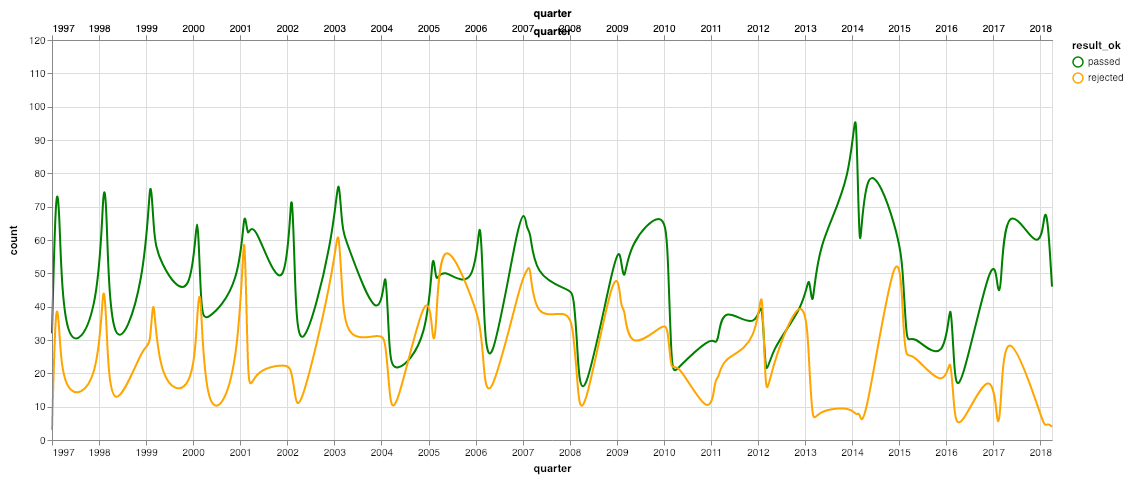

In [149]:
d = pd.DataFrame(all_laws.groupby(['quarter', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})
d['quarter'] = pd.to_datetime(d['quarter'])


# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['quarter'], empty='none')
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='quarter:T',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))
selectors = alt.Chart().mark_point().encode(
    x='quarter:Q',
    opacity=alt.value(0),).add_selection(nearest)
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'count:Q', alt.value(' ')))
rules = alt.Chart().mark_rule(color='gray').encode(
    x='quarter:Q',).transform_filter(nearest)

alt.layer(line, selectors, points, rules, text, data=d, width=1000, height=400)

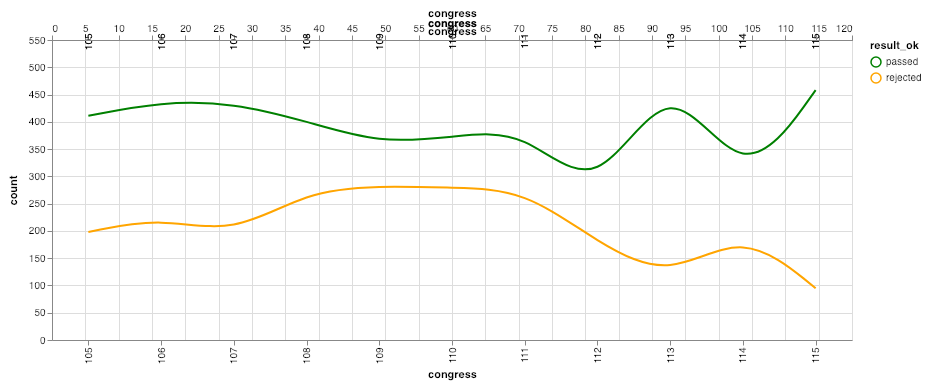

In [257]:
d = pd.DataFrame(all_laws.groupby(['congress', 'result_ok']).size()).reset_index()
d = d.rename(columns={0: 'count'})


# Chart
nearest = alt.selection(type='single', nearest=True, on='mouseover',
                        fields=['quarter'], empty='none')
line = alt.Chart().mark_line(interpolate='basis').encode(
    x='congress:O',
    y='count:Q',
    color=alt.Color('result_ok:N', 
                    scale=alt.Scale(domain=['passed', 'rejected'], 
                                    range=['green', 'orange'])))
selectors = alt.Chart().mark_point().encode(
    x='congress:Q',
    opacity=alt.value(0),).add_selection(nearest)
points = line.mark_point().encode(
    opacity=alt.condition(nearest, alt.value(1), alt.value(0)))
text = line.mark_text(align='left', dx=5, dy=-5).encode(
    text=alt.condition(nearest, 'count:Q', alt.value(' ')))
rules = alt.Chart().mark_rule(color='gray').encode(
    x='congress:Q',).transform_filter(nearest)

alt.layer(line, selectors, points, rules, text, data=d, width=800, height=300)

## Historical Concordance Inter and Intra Party

### Inter Party

In [156]:
# Kendal: coeffient that mesures difference between concordante pairs and discordant pairs
all_laws[['democrats_yes', 'republican_yes', 'democrats_no', 'republican_no']].corr('kendall')

,democrats_yes,republican_yes,democrats_no,republican_no
democrats_yes,1.000000,-0.240580,-0.738845,0.135862
republican_yes,-0.240580,1.000000,0.122328,-0.752713
democrats_no,-0.738845,0.122328,1.000000,-0.077834
republican_no,0.135862,-0.752713,-0.077834,1.000000


The correlation between "yes" of democrats and republican is -0.24 and for "no" is -0.07. It means, an "yes" position is more polemic and generates more divergence than a "no" position. 

On the other hand, the coefficients for "yes" and "no" for democrats and republican are about 0.12 and 0.13 which indicates a concordance in the opposite direction. hehehe

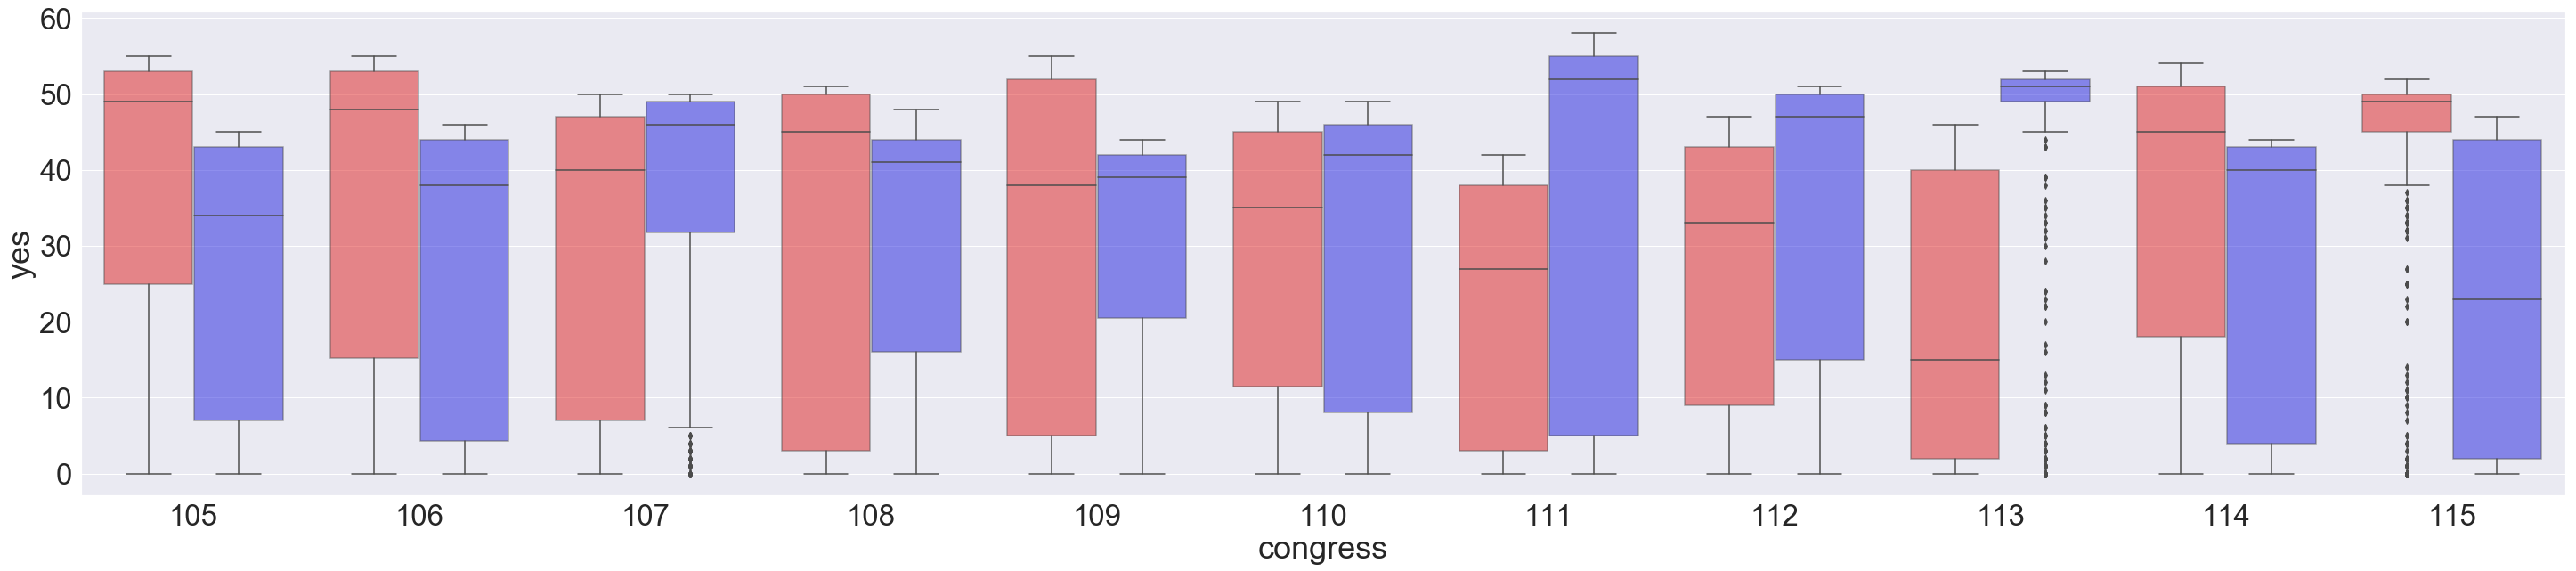

In [252]:
r = all_laws[['republican_yes', 'congress']].rename(columns={'republican_yes': 'yes'})
r['party'] = 'republican'
d = all_laws[['democrats_yes', 'congress']].rename(columns={'democrats_yes': 'yes'})
d['party'] = 'democrats'
d = pd.concat([r, d], axis=0)

plt.figure(figsize=(50, 10))
ax = sns.boxplot(x='congress', y='yes', hue='party', data=d, palette=pal, boxprops=dict(alpha=.5))
ax.legend_.remove()

### Intra Party